**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x


1.       Check the type of co factors, if some have a lot of missing value or typo, correct them or let them out. Then for continuous factors, check the person correlation coefficients,  if Pearson correlation near 1 or -1 among any two, one should be gone in multiple regression. For category factors, check independency of any two. if most count appear in the diagonal of the contingence table, one of the two category variables should be gone.
2.       Draw the scatter plots between the continuous outcome and each independent quantitative factor to see the association: if linear trend is shown, the factor is in, if non-linear effect is shown, transformation is needed. If no trend, like random, the independent factor could be out.
3.       Suppose the dependent variable should be independent. If the dependent variable is related to time, check the auto correlation, if autocorrelation exists,  time series modeling say Autoreg might be used.
4.       Do PCA analysis to see if there are still multicolinearity among the independent factors, if some eigen-value is near zero, you may drop one of them, or define a new factor (transformation) .
5.       If the sample size is large enough, say 10 (at least) times higher of the unknown parameter number, you can  do multiple regressions, you may use auto select option, such as forward backward or best, which will select independent factors for you.
6.       Number of parameters: interception: count 1, continuous factor, each counts 1, categorical factor with level of k, count as k-1.
7.       Check outliers by leverage or CooksD or Residual, if exists you may delete them or do both model with and without the outliers.
8.       Check normality of residuals from the multi variable regression,    if violated, do transformation, variance homogeneity exist: transformation on some independent factor, variance homogeneity doesn’t exist: transformation on dependent factor. Those may improve your model fitting.
9.       You may use Akaike’s information criterion or Bayesian information criterion or Mallows’ CP to decide how many factors should be in. Using them is better than comparison of  R2.
10.   Check interaction among the independent factors, the interaction among two quantitative predictors, means there is joint effect; the effect of one factor varies across the level of another factor. If the interaction between an quantitation factor and a category factor, say gender, it means the effect of the quantitative, slope,  is different between males and females.

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [46]:
import numpy as np
import pandas as pd
from collections import defaultdict

def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [28]:
y_name = 'CO2'
df = pd.read_csv('datatrainingcopy.csv')
columns2remove = ['date', 'Number']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1
1,23.15,27.2675,429.5,714.00,0.004783,1
2,23.15,27.2450,426.0,713.50,0.004779,1
3,23.15,27.2000,426.0,708.25,0.004772,1
4,23.10,27.2000,426.0,704.50,0.004757,1


# Data Partitioning

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [30]:
attributes = [col for col in df.columns if col != y_name]
X = df[attributes].values
y = df[y_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [32]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [-4.66462970e+02 -3.41988357e+02  3.25301180e-01  2.39777923e+06
  1.44509105e+02]
Intercept: 
 9693.97993341363


In [34]:
y_pred = reg.predict(X_test)

In [35]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.861
MSE: 14537.226
MAE: 83.413


## Linear Regression in 2 dimensions

In [36]:
reg = LinearRegression()
reg.fit(X_train.T[0].reshape(-1, 1), y_train)
y_pred = reg.predict(X_test.T[0].reshape(-1, 1))

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.317
MSE: 71491.612
MAE: 165.099


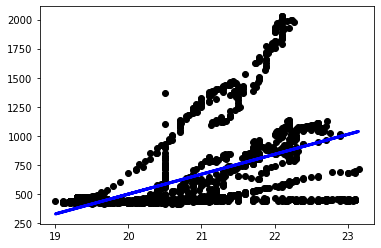

In [37]:
plt.scatter(X_test.T[0], y_test,  color='black')
plt.plot(X_test.T[0], y_pred, color='blue', linewidth=3)
plt.show()

# Lasso

In [38]:
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [ 1.20334087e+02  2.45529629e+01 -1.86082209e-02  0.00000000e+00
  3.40172255e+02]
Intercept: 
 -2577.3768121193307


In [39]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.728
MSE: 28525.349
MAE: 122.011


In [40]:
reg = LinearRegression()
reg.fit(X_train.T[0].reshape(-1, 1), y_train)
y_pred = reg.predict(X_test.T[0].reshape(-1, 1))


# Ridge

In [41]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [ 1.22929825e+02  2.44203928e+01 -9.03942098e-02  3.00712723e+01
  3.73524817e+02]
Intercept: 
 -2626.072003564059


In [42]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.728
MSE: 28480.902
MAE: 122.195


# Slides Example

Coefficients: 
 [58.87472632]
Mean squared error: 3.40
Coefficient of determination: 0.93
1.4326654016445288


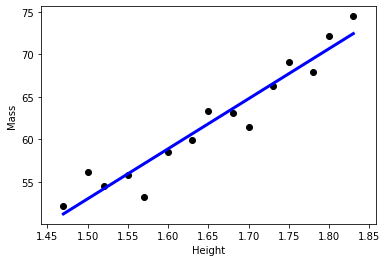

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model

Height = np.array([1.47, 1.50, 1.52, 1.55, 1.57, 1.60, 1.63, 1.65, 1.68, 1.70, 1.73, 1.75, 1.78, 1.80, 1.83])
Mass = np.array([52.21, 56.12, 54.48, 55.84, 53.20, 58.57, 59.93, 63.29, 63.11, 61.47, 66.28, 69.10, 67.92, 
                 72.19, 74.46])

diabetes_X_train = Height
diabetes_y_train = Mass

diabetes_X_test = Height
diabetes_y_test = Mass

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train.reshape(-1, 1), diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))
print(mean_absolute_error(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
plt.xlabel('Height')
plt.ylabel('Mass')

#plt.xticks(())
#plt.yticks(())

plt.show()

# Logistic Regression

In [65]:



class_name = 'Occupancy'
df = pd.read_csv('datatrainingcopy.csv', skipinitialspace=True, na_values='?', keep_default_na=True)

columns2remove = ['date', 'Number']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1
1,23.15,27.2675,429.5,714.00,0.004783,1
2,23.15,27.2450,426.0,713.50,0.004779,1
3,23.15,27.2000,426.0,708.25,0.004772,1
4,23.10,27.2000,426.0,704.50,0.004757,1


In [66]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1
1,23.15,27.2675,429.5,714.00,0.004783,1
2,23.15,27.2450,426.0,713.50,0.004779,1
3,23.15,27.2000,426.0,708.25,0.004772,1
4,23.10,27.2000,426.0,704.50,0.004757,1


In [67]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report

In [68]:
selected_columns = ['Occupancy']

attributes = [col for col in df.columns if col != class_name]
X = df[selected_columns].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [69]:
X.shape

(8143, 1)

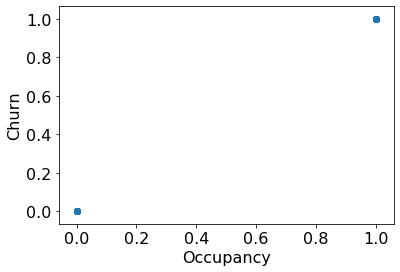

In [70]:
plt.scatter(X_train, y_train)
plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       1.00      1.00      1.00       519

    accuracy                           1.00      2443
   macro avg       1.00      1.00      1.00      2443
weighted avg       1.00      1.00      1.00      2443



In [55]:
from scipy.special import expit

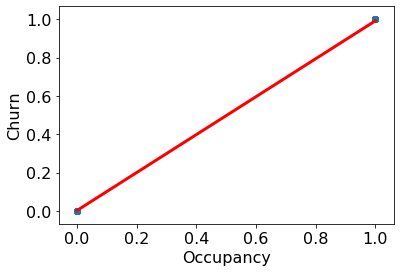

In [56]:
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [73]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

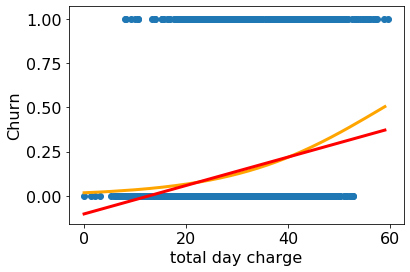

In [74]:
plt.scatter(X_train, y_train)

loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='orange', linewidth=3)

plt.plot(sorted(X_test), reg.coef_ * sorted(X_test) + reg.intercept_, color='red', linewidth=3)


plt.xlabel(selected_columns[0], fontsize=16)
plt.ylabel('Churn', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()